In [ ]:
import os
import cv2
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.io


import tensorflow as tf
from keras import backend as K
from keras.models import Model
from keras.layers import Input, Conv2D, MaxPooling2D, Reshape, Bidirectional, LSTM, Dense, Lambda, Activation, BatchNormalization, Dropout
from keras.optimizers import Adam

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

home_path = "/content/drive/Shareddrives/Data2040FinalProj/data/IIIT5K/"
train_label_path = home_path + "traindata.mat"
test_label_path = home_path + "testdata.mat"
train_image_path = home_path + "train/"
test_image_path = home_path + "test/"

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
train_label = scipy.io.loadmat(train_label_path)
test_label = scipy.io.loadmat(test_label_path)

In [ ]:
images = [train_image_path + i[0][0].split("/")[1] for i in train_label['traindata'][0]]
labels = [i[1][0] for i in train_label['traindata'][0]]
characters = set(char for label in labels for char in label)

In [ ]:
test_img = [test_image_path + i[0][0].split("/")[1] for i in test_label['testdata'][0]]
total_img = images+test_img

test_labels = [i[1][0] for i in test_label['testdata'][0]]
total_labels = labels + test_labels

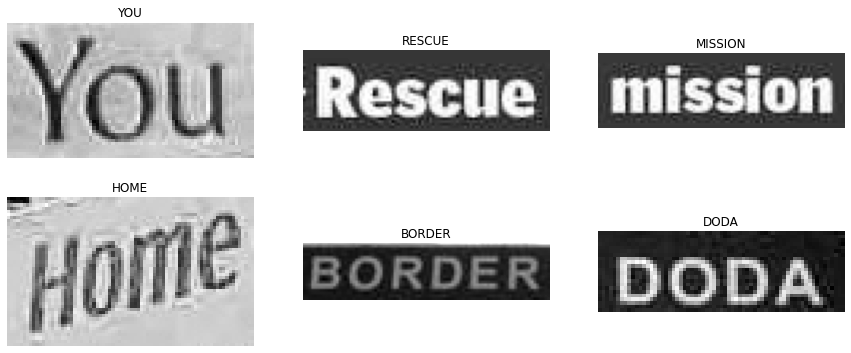

In [ ]:
plt.figure(figsize=(15, 20))

for i in range(6):
    ax = plt.subplot(2, 3, i+1)
    img_dir = images[i]
    image = cv2.imread(img_dir, cv2.IMREAD_GRAYSCALE)
    plt.imshow(image, cmap = 'gray')
    plt.title(labels[i], fontsize=12)
    plt.axis('off')

plt.subplots_adjust(wspace=0.2, hspace=-0.8)

In [ ]:
def preprocess(img):
      img = cv2.resize(img, (128, 32))
      (h, w) = img.shape
      # print(h, w)
      
      final_img = np.ones([32, 128])*255 # blank white image
      
      # # crop
      # if w > 128:
      #     img = img[:, :128]
          
      # if h > 32:
      #     img = img[:32, :]
      
      
      final_img[:h, :w] = img

      return cv2.rotate(final_img, cv2.ROTATE_90_CLOCKWISE)

In [ ]:
train_size = 3000
valid_size= 500

In [ ]:
train_x = []

for i in range(train_size):
    img_dir = total_img[i]
    image = cv2.imread(img_dir, cv2.IMREAD_GRAYSCALE)
    image = preprocess(image)
    image = image/255.
    # print(image.shape)
    train_x.append(image)

In [ ]:
valid_x = []

for i in range(valid_size):
    img_dir = total_img[train_size+i]
    image = cv2.imread(img_dir, cv2.IMREAD_GRAYSCALE)
    image = preprocess(image)
    image = image/255.
    valid_x.append(image)

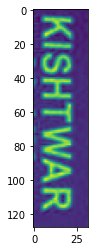

In [ ]:
plt.imshow(train_x[15])
image = cv2.imread(images[15], cv2.IMREAD_GRAYSCALE)
#plt.imshow(image)

In [ ]:
train_x = np.array(train_x).reshape(-1, 128, 32, 1)
valid_x = np.array(valid_x).reshape(-1, 128, 32, 1)

In [ ]:
alphabets = u"0123456789ABCDEFGHIJKLMNOPQRSTUVWXYZ-' "
max_str_len = 24 # max length of input labels
num_of_characters = len(alphabets) + 1 # +1 for ctc pseudo blank
num_of_timestamps = 32 # max length of predicted labels


def label_to_num(label):
    label_num = []
    for ch in label:
        label_num.append(alphabets.find(ch))
        
    return np.array(label_num)

def num_to_label(num):
    ret = ""
    for ch in num:
        if ch == -1:  # CTC Blank
            break
        else:
            ret+=alphabets[ch]
    return ret


In [ ]:
labels[0]

'YOU'

In [ ]:
name = 'JEBASTIN'
print(name, '\n',label_to_num(name))

JEBASTIN 
 [19 14 11 10 28 29 18 23]


### Train model

In [ ]:
train_y = np.ones([train_size, max_str_len]) * -1
train_label_len = np.zeros([train_size, 1])
train_input_len = np.ones([train_size, 1]) * (num_of_timestamps-2)
train_output = np.zeros([train_size])

for i in range(train_size):
    train_label_len[i] = len(total_labels[i])
    train_y[i, 0:len(total_labels[i])]= label_to_num(total_labels[i])    

In [ ]:
valid_y = np.ones([valid_size, max_str_len]) * -1
valid_label_len = np.zeros([valid_size, 1])
valid_input_len = np.ones([valid_size, 1]) * (num_of_timestamps-2)
valid_output = np.zeros([valid_size])

for i in range(valid_size):
    valid_label_len[i] = len(total_labels[train_size+i])
    valid_y[i, 0:len(total_labels[train_size+i])]= label_to_num(total_labels[train_size+i])    

In [ ]:
print('True label : ',total_labels[0] , '\ntrain_y : ',train_y[0],'\ntrain_label_len : ',train_label_len[0], 
      '\ntrain_input_len : ', train_input_len[0])

True label :  YOU 
train_y :  [34. 24. 30. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1.
 -1. -1. -1. -1. -1. -1.] 
train_label_len :  [3.] 
train_input_len :  [30.]


In [ ]:
### new model:
input_data = Input(shape=(128, 32, 1), name='input')

inner = Conv2D(64, (3, 3), padding='same', name='conv1', kernel_initializer='he_normal')(input_data)  
inner = BatchNormalization()(inner)
inner = Activation('relu')(inner)
inner = MaxPooling2D(pool_size=(2, 2), name='max1')(inner)

inner = Conv2D(128, (3, 3), padding='same', name='conv2', kernel_initializer='he_normal')(inner)
inner = BatchNormalization()(inner)
inner = Activation('relu')(inner)
inner = MaxPooling2D(pool_size=(2, 2), name='max2')(inner)
inner = Dropout(0.3)(inner)

inner = Conv2D(256, (3, 3), padding='same', name='conv3', kernel_initializer='he_normal')(inner)
inner = BatchNormalization()(inner)
inner = Activation('relu')(inner)
inner = MaxPooling2D(pool_size=(1, 2), name='max3')(inner)
inner = Dropout(0.3)(inner)

inner = Conv2D(512, (3, 3), padding='same', name='conv4', kernel_initializer='he_normal')(inner)
inner = BatchNormalization()(inner)
inner = Activation('relu')(inner)
inner = MaxPooling2D(pool_size=(1,2), name='max4')(inner)
inner = Dropout(0.3)(inner)

inner = Conv2D(512, (3, 3), padding='same', name='conv5', kernel_initializer='he_normal')(inner)
inner = BatchNormalization()(inner)
inner = Activation('relu')(inner)
inner = MaxPooling2D(pool_size=(1,2), name='max5')(inner)
inner = Dropout(0.3)(inner)

# CNN to RNN
inner = Reshape(target_shape=((32, 512)), name='reshape')(inner)
inner = Dense(64, activation='relu', kernel_initializer='he_normal', name='dense1')(inner)

## RNN
inner = Bidirectional(LSTM(512, return_sequences=True), name = 'lstm1')(inner)
inner = Bidirectional(LSTM(512, return_sequences=True), name = 'lstm2')(inner)

## OUTPUT
inner = Dense(num_of_characters, kernel_initializer='he_normal',name='dense2')(inner)
y_pred = Activation('softmax', name='softmax')(inner)

model = Model(inputs=input_data, outputs=y_pred)
model.summary()

Model: "model_22"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 128, 32, 1)]      0         
_________________________________________________________________
conv1 (Conv2D)               (None, 128, 32, 64)       640       
_________________________________________________________________
batch_normalization_96 (Batc (None, 128, 32, 64)       256       
_________________________________________________________________
activation_96 (Activation)   (None, 128, 32, 64)       0         
_________________________________________________________________
max1 (MaxPooling2D)          (None, 64, 16, 64)        0         
_________________________________________________________________
conv2 (Conv2D)               (None, 64, 16, 128)       73856     
_________________________________________________________________
batch_normalization_97 (Batc (None, 64, 16, 128)       512

In [ ]:
def ctc_lambda_func(args):
    y_pred, labels, input_length, label_length = args
    # the 2 is critical here since the first couple outputs of the RNN
    # tend to be garbage
    y_pred = y_pred[:, 2:, :]
    return K.ctc_batch_cost(labels, y_pred, input_length, label_length)

In [ ]:
labels_nw = Input(name='gtruth_labels', shape=[max_str_len], dtype='float32')
input_length = Input(name='input_length', shape=[1], dtype='int64')
label_length = Input(name='label_length', shape=[1], dtype='int64')

ctc_loss = Lambda(ctc_lambda_func, output_shape=(1,), name='ctc')([y_pred, labels_nw, input_length, label_length])
model_final = Model(inputs=[input_data, labels_nw, input_length, label_length], outputs=ctc_loss)

In [ ]:

model_final.compile(loss={'ctc': lambda y_true, y_pred: y_pred}, optimizer=Adam(lr = 0.001))

history=model_final.fit(x=[train_x, train_y, train_input_len, train_label_len], y=train_output, 
                validation_data=([valid_x, valid_y, valid_input_len, valid_label_len], valid_output),
                epochs=50, batch_size=10)

Epoch 1/50
300/300 [==============================] - 380s 1s/step - loss: 19.9580 - val_loss: 17.9294
Epoch 2/50
300/300 [==============================] - 373s 1s/step - loss: 16.5600 - val_loss: 17.5708
Epoch 3/50
300/300 [==============================] - 374s 1s/step - loss: 14.1504 - val_loss: 12.9310
Epoch 4/50
300/300 [==============================] - 374s 1s/step - loss: 9.4982 - val_loss: 10.0115
Epoch 5/50
300/300 [==============================] - 371s 1s/step - loss: 5.8055 - val_loss: 7.9811
Epoch 6/50
300/300 [==============================] - 372s 1s/step - loss: 4.1166 - val_loss: 7.0297
Epoch 7/50
300/300 [==============================] - 374s 1s/step - loss: 2.9294 - val_loss: 6.5818
Epoch 8/50
300/300 [==============================] - 378s 1s/step - loss: 2.3546 - val_loss: 6.1596
Epoch 9/50
300/300 [==============================] - 378s 1s/step - loss: 1.7910 - val_loss: 6.2982
Epoch 10/50
300/300 [==============================] - 373s 1s/step - loss: 1.5818 -

In [ ]:
#### Save model:
import os
model_name = '6x.h5'
save_dir = os.path.join(os.getcwd(), 'saved_models')
 
# Save model and weights
if not os.path.isdir(save_dir):
    os.makedirs(save_dir)
model_path = os.path.join(save_dir, model_name)
model.save(model_path)
print('Saved trained model at %s ' % model_path)



Saved trained model at /content/saved_models/6x.h5 


In [ ]:
#### load model:
from keras.models import load_model
import pandas as pd
import PIL
import numpy as np
model = load_model("/content/saved_models/6x.h5")


In [ ]:
preds = model.predict(valid_x)
decoded = K.get_value(K.ctc_decode(preds, input_length=np.ones(preds.shape[0])*preds.shape[1], 
                                   greedy=True)[0][0])

prediction = []
for i in range(valid_size):
    prediction.append(num_to_label(decoded[i]))

In [ ]:
prediction

['5',
 'TNATE',
 'SIETIS',
 'CLAKETHMATE',
 'THE',
 'CPOTTING',
 'SHED',
 'THE',
 'IELL4',
 'HILL',
 'WINEPIELD',
 'ABEOF',
 'ZLED',
 'ESITIN5',
 '2002',
 'BCRANAEE',
 'COTTAGN',
 'TWENTY',
 'VEIGHT',
 '54',
 '623',
 'AWELCOME',
 'TO',
 'ISIGN',
 'ROLAND',
 'HOWARD',
 'MD',
 'REROS',
 'OGLENALAE',
 'MUM',
 'AND',
 'DAD',
 'ROORN',
 '23',
 '138',
 '122',
 'WISTERIA',
 '3LOUSE',
 'WELE',
 'VLLE',
 'TGLO',
 '3GULL',
 'ANEN',
 'BOAGO',
 'VTQOUUO',
 'MILL',
 'BCOTTAG',
 'BFOUR',
 'BHOLLY',
 'BOTTAE',
 'SRDGER',
 'BCOTTAGE',
 'SCOTTAGE',
 'WCROEARA',
 'THOUSE',
 '13',
 'IIIRNS',
 'THO7',
 'BCRARVION',
 '23',
 'BCARDET',
 'BLOY',
 'BGLEVEST',
 'BHOMN',
 'BRIOEAT',
 'THOUSE',
 'LS',
 'BIEL',
 'STDE',
 'VOAK',
 'AM5',
 'LAZE',
 'BLOE8',
 'LRRO',
 'K',
 'OTRS',
 'LT',
 'PORTAS',
 'LF',
 'PLOLK',
 'EOIT',
 'RTBL9',
 'BSES',
 'SHE9',
 'VV6',
 'BIG',
 'RO8',
 'LST',
 'ATPS',
 'BSIOIY',
 'BEANEN',
 'VQORIEEE',
 'LE',
 'LU3',
 '12',
 '6S',
 'O6',
 'FEOOS',
 'VBWELIRE',
 'TBOU3',
 'E',
 'AN',
 '5',
 '

### CRNN model result:


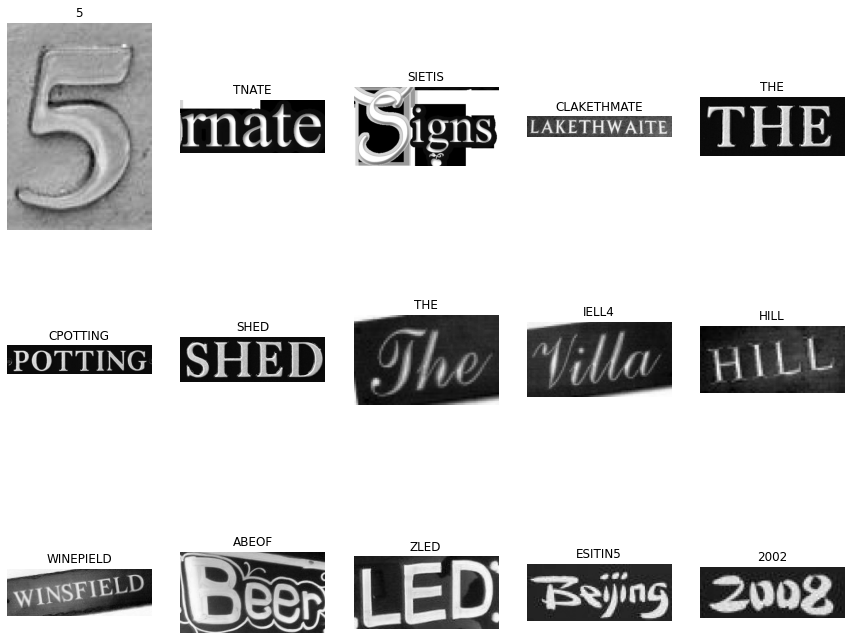

In [ ]:
plt.figure(figsize=(15, 30))

for i in range(15):
    ax = plt.subplot(3, 5, i+1)
    img_dir = total_img[train_size+i]
    image = cv2.imread(img_dir, cv2.IMREAD_GRAYSCALE)
    plt.imshow(image, cmap = 'gray')
    plt.title(prediction[i], fontsize=12)
    plt.axis('off')

plt.subplots_adjust(wspace=0.2, hspace=-0.8)

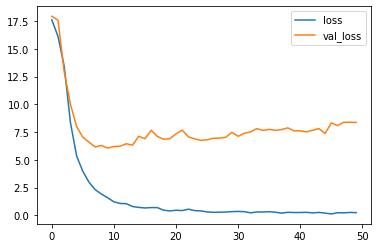

In [ ]:
history_frame = pd.DataFrame(history.history)
history_frame.loc[:, ['loss', 'val_loss']].plot()

In [ ]:
y_true = total_labels[train_size:train_size+valid_size]
correct_char = 0
total_char = 0
correct = 0

for i in range(valid_size):
    pr = prediction[i]
    tr = y_true[i]
    total_char += len(tr)
    
    for j in range(min(len(tr), len(pr))):
        if tr[j] == pr[j]:
            correct_char += 1
            
    if pr == tr :
        correct += 1 
    
print('Correct characters predicted : %.2f%%' %(correct_char*100/total_char))
print('Correct words predicted      : %.2f%%' %(correct*100/valid_size))

Correct characters predicted : 39.61%
Correct words predicted      : 29.60%
